In [49]:
import ee
import geemap
import pandas as pd

### The data has been acquired from https://soilgrids.org/ 

In [2]:
# Initialize Earth Engine
ee.Initialize()

In [3]:
# Load FAO GAUL dataset
fao_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level2")

# Filter for Bangladesh
bangladesh_boundaries = fao_boundaries.filter(ee.Filter.eq("ADM0_NAME", "Bangladesh"))

In [4]:
# Define SoilGrids layers for topsoil depth (0-5 cm)
sand = ee.Image("projects/soilgrids-isric/sand_mean").select(0).rename("Sand")
silt = ee.Image("projects/soilgrids-isric/silt_mean").select(0).rename("Silt")
clay = ee.Image("projects/soilgrids-isric/clay_mean").select(0).rename("Clay")
nitrogen = ee.Image("projects/soilgrids-isric/nitrogen_mean").select(0).rename("Nitrogen")
soc = ee.Image("projects/soilgrids-isric/soc_mean").select(0).rename("SOC")

In [5]:
# Combine layers into a single image
soil_image = sand.addBands([silt, clay, nitrogen, soc])

In [6]:
# Get all ADM2 boundaries for Bangladesh
bangladesh_boundaries = ee.FeatureCollection("FAO/GAUL/2015/level2").filter(
    ee.Filter.eq("ADM0_NAME", "Bangladesh")
)
adm2_list = bangladesh_boundaries.aggregate_array("ADM2_NAME").getInfo()

In [7]:
# Initialize an empty list to store results
all_results = []

# Loop through each ADM2 boundary
for adm2_name in adm2_list:
    print(f"Processing {adm2_name}...")
    # Filter for the current ADM2 boundary
    adm2_boundary = bangladesh_boundaries.filter(ee.Filter.eq("ADM2_NAME", adm2_name))
    
    # Generate 500 random points within the boundary
    random_points = ee.FeatureCollection.randomPoints(
        region=adm2_boundary.geometry(),
        points=500,
        seed=42  # For reproducibility
    )
    
    # Sample soil data at these random points
    sampled_data = soil_image.sampleRegions(
        collection=random_points,
        scale=250,
        geometries=True  # Include geometry for coordinates
    )
    
    # Convert sampled data to a dictionary
    sampled_dict = sampled_data.getInfo()
    
    # Extract data from features
    for feature in sampled_dict['features']:
        coords = feature['geometry']['coordinates']
        properties = feature['properties']
        properties.update({
            "Longitude": coords[0],
            "Latitude": coords[1],
            "ADM2_NAME": adm2_name
        })
        all_results.append(properties)

# Convert results to a Pandas DataFrame
df = pd.DataFrame(all_results)

Processing Barisal...
Processing Bhola...
Processing Jhalokati...
Processing Patuakhali...
Processing Pirojpur...
Processing Bandarban...
Processing Brahamanbaria...
Processing Chandpur...
Processing Chittagong...
Processing Comilla...
Processing Cox's Bazar...
Processing Feni...
Processing Khagrachhari...
Processing Lakshmipur...
Processing Noakhali...
Processing Rangamati...
Processing Dhaka...
Processing Faridpur...
Processing Gazipur...
Processing Gopalganj...
Processing Jamalpur...
Processing Kishoreganj...
Processing Madaripur...
Processing Manikganj...
Processing Munshiganj...
Processing Mymensingh...
Processing Narayanganj...
Processing Narsingdi...
Processing Netrakona...
Processing Rajbari...
Processing Shariatpur...
Processing Sherpur...
Processing Tangail...
Processing Bagerhat...
Processing Chuadanga...
Processing Jessore...
Processing Jhenaidah...
Processing Khulna...
Processing Kushtia...
Processing Magura...
Processing Meherpur...
Processing Narail...
Processing Satkhir

In [8]:
# Save to CSV
output_csv = "soil_sampled_points.csv"
df.to_csv(output_csv, index=False)


## Exploratory Data Analysis 

In [9]:
import numpy as np 
import pandas as pd 
import plotly.express as px
from scipy.stats import boxcox
from scipy.special import inv_boxcox

In [10]:
df = pd.read_csv('soil_sampled_points.csv')
df.head()

Clay  Nitrogen  SOC  Sand  Silt  Longitude   Latitude ADM2_NAME
0   250      3450  393   269   482  90.424454  22.618200   Barisal
1   252      2171  232   228   520  90.305871  22.860100   Barisal
2   254      4942  430   242   504  90.154161  22.912256   Barisal
3   274      2406  260   268   458  90.409891  23.035372   Barisal
4   257      5733  513   254   489  90.154539  22.989459   Barisal

In [11]:
df['Nitrogen%'] = df['Nitrogen']/10000
df['SOC%'] = df['SOC']/100

In [12]:
# Summary statistics for numerical columns
print(df.select_dtypes(include=["float64","int64"]).describe())

               Clay      Nitrogen           SOC          Sand          Silt  \
count  28169.000000  28169.000000  28169.000000  28169.000000  28169.000000   
mean     315.172637   2182.139764    260.386773    277.847989    406.975043   
std       51.237933    905.291192     93.337936     81.314132     65.674774   
min      206.000000   1153.000000    128.000000     76.000000    190.000000   
25%      278.000000   1615.000000    200.000000    214.000000    361.000000   
50%      301.000000   1870.000000    228.000000    277.000000    403.000000   
75%      341.000000   2370.000000    285.000000    336.000000    452.000000   
max      589.000000   6757.000000    955.000000    553.000000    592.000000   

          Longitude      Latitude     Nitrogen%          SOC%  
count  28169.000000  28169.000000  28169.000000  28169.000000  
mean      90.101618     23.911068      0.218214      2.603868  
std        1.072926      1.175757      0.090529      0.933379  
min       88.037258     20.75916

In [13]:
# Summary statistics for numerical columns
print(df.select_dtypes(include=["float64","int64"]).isnull().sum())

Clay         0
Nitrogen     0
SOC          0
Sand         0
Silt         0
Longitude    0
Latitude     0
Nitrogen%    0
SOC%         0
dtype: int64


In [14]:
# getting all numerical columns 
num_col = df.select_dtypes(include=["float64","int64"])
num_col

Clay  Nitrogen  SOC  Sand  Silt  Longitude   Latitude  Nitrogen%  SOC%
0       250      3450  393   269   482  90.424454  22.618200     0.3450  3.93
1       252      2171  232   228   520  90.305871  22.860100     0.2171  2.32
2       254      4942  430   242   504  90.154161  22.912256     0.4942  4.30
3       274      2406  260   268   458  90.409891  23.035372     0.2406  2.60
4       257      5733  513   254   489  90.154539  22.989459     0.5733  5.13
...     ...       ...  ...   ...   ...        ...        ...        ...   ...
28164   303      2597  341   208   489  90.110806  22.091164     0.2597  3.41
28165   253      3405  336   218   528  90.145766  22.014151     0.3405  3.36
28166   355      2771  345   158   487  90.053967  22.026639     0.2771  3.45
28167   282      3604  374   235   482  90.090942  22.159865     0.3604  3.74
28168   337      3706  373   187   475  89.995795  22.018314     0.3706  3.73

[28169 rows x 9 columns]

In [15]:
# plotting to understand the data distribution 
# Plot histograms for all numerical columns
for col in num_col.columns:
    fig = px.histogram(num_col, x=col, nbins=100, title=f"Histogram of {col}")
    fig.show()

In [16]:
nitrogen_stats = df['Nitrogen%'].describe()
soc_stats = df['SOC%'].describe()

skew_nitrogen = df['Nitrogen%'].skew()
skew_soc = df['SOC%'].skew()

kurt_nitrogen = df['Nitrogen%'].kurtosis()
kurt_soc = df['SOC%'].kurtosis()

print(f"Nitrogen - Skewness: {skew_nitrogen}, Kurtosis: {kurt_nitrogen}")
print(f"SOC - Skewness: {skew_soc}, Kurtosis: {kurt_soc}")


Nitrogen - Skewness: 2.069691026048014, Kurtosis: 4.261867849480806
SOC - Skewness: 1.9823081070027293, Kurtosis: 4.543584609358144


In [17]:
df['Nitrogen_log'] = np.log1p(df['Nitrogen%'])  
df['SOC_log'] = np.log1p(df['SOC%'])


In [18]:
print(f"Log Transformed Nitrogen Skewness: {df['Nitrogen_log'].skew()}")
print(f"Log Transformed Nitrogen Kurtosis: {df['Nitrogen_log'].kurtosis()}")
print(f"Log Transformed SOC Skewness: {df['SOC_log'].skew()}")
print(f"Log Transformed SOC Kurtosis: {df['SOC_log'].kurtosis()}")


Log Transformed Nitrogen Skewness: 1.8726482181157376
Log Transformed Nitrogen Kurtosis: 3.3411494157558335
Log Transformed SOC Skewness: 1.3252056226798608
Log Transformed SOC Kurtosis: 1.4549510259340575


## Modelling

In [19]:
from pycaret.regression import *

In [31]:
# PyCaret setup
reg_setup = setup(data=num_col[['Nitrogen%','SOC%','Sand','Silt','Clay']], target='SOC%',preprocess= True, transformation= False,
                  session_id = 123)

In [32]:
# compare baseline models
best = compare_models()

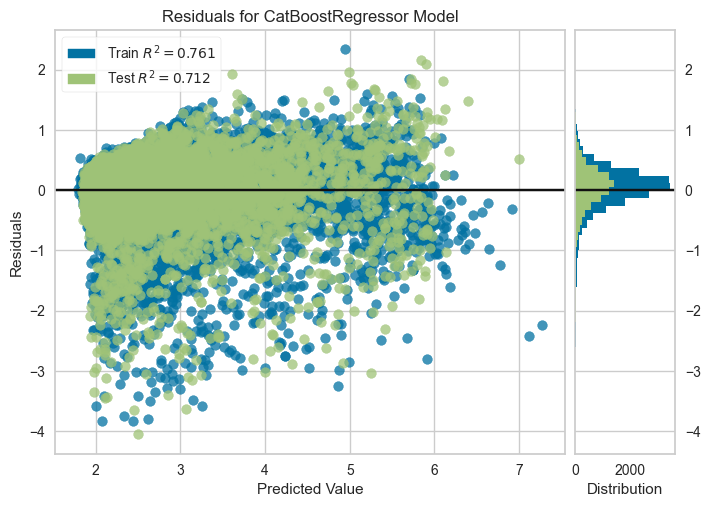

In [33]:
# plot residuals
plot_model(best, plot = 'residuals')

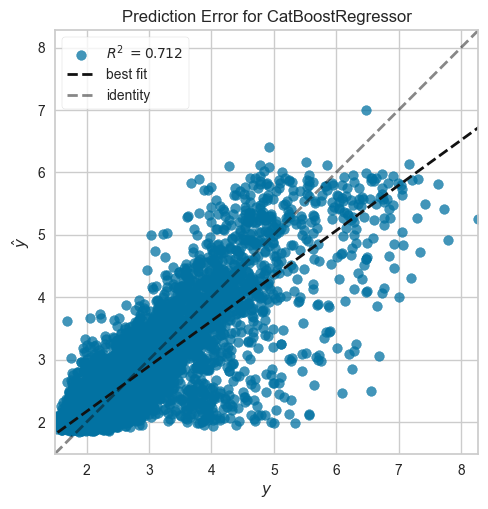

In [34]:
# plot error
plot_model(best, plot = 'error')

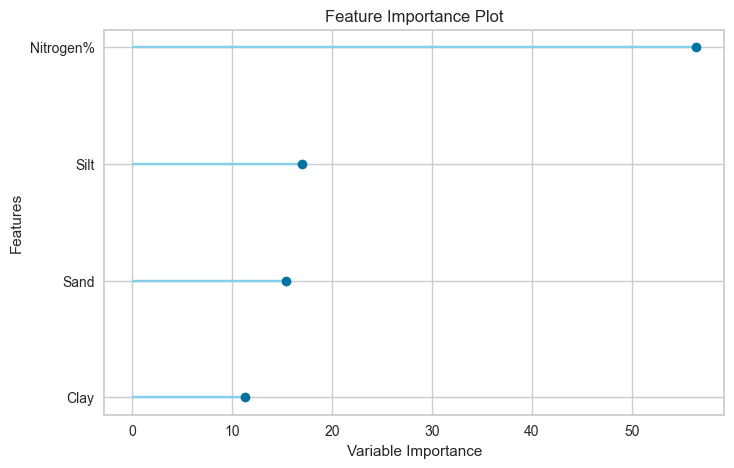

In [35]:
# plot feature importance
plot_model(best, plot = 'feature')

In [36]:
print(best.get_params())

{'loss_function': 'RMSE', 'border_count': 254, 'verbose': False, 'task_type': 'CPU', 'random_state': 123}


### Further tunning 

In [37]:
from catboost import CatBoostRegressor

# Custom CatBoost model with MAE as the loss function
custom_catboost = CatBoostRegressor(
    loss_function='MAE',
    border_count=254,
    verbose=False,
    task_type='CPU',
    random_state=123
)


In [39]:
# train model
ct = create_model('catboost')

In [40]:

# tune model
tuned_dt = tune_model(ct, optimize = 'MAE')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [41]:
# tune model
tuned_dt = tune_model(ct, optimize = 'R2')

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [42]:
# tune model optuna
tune_model(ct, search_library = 'optuna')

Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [44]:

# tune model scikit-optimize
tune_model(ct, search_library = 'scikit-optimize')

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [45]:
# ensemble model
bagged_dt = ensemble_model(ct)

In [46]:

# ensemble model
boosted_dt = ensemble_model(ct, method = 'Boosting')

In [48]:
# blend models
blender = blend_models(compare_models(n_select = 3))

-- As the improvment isn't significant. So,its better to keep only 1 model for the prediction i.e. 'catboost'

## Validation on ipage data 

##### Enriching Ipage data with Sand silt and clay data -- All the regions present in Ipage data is from Rangpur District of Bangladesh

In [50]:
# Getting data for Rangpur District 
# Filter for Rangpur district (ADM2 level)
rangpur_boundary = bangladesh_boundaries.filter(ee.Filter.eq("ADM2_NAME", "Rangpur"))

# Generate 617 random points within Rangpur district
random_points = ee.FeatureCollection.randomPoints(
    region=rangpur_boundary.geometry(),
    points=617,
    seed=42  # For reproducibility
)

# Sample soil data at the random points
sampled_data = soil_image.sampleRegions(
    collection=random_points,
    scale=250,
    geometries=True  # Include geometry for coordinates
)
# Convert the sampled data to a GeoDataFrame and save it locally
out_file = "Rangpur_Soil_Data.csv"
geemap.ee_to_csv(sampled_data, filename=out_file)

print(f"Data saved locally as {out_file}")

Data saved locally as Rangpur_Soil_Data.csv


In [57]:
df_test = pd.read_csv('Rangpur_Soil_Data.csv')
df_test.head()

Clay  Nitrogen  SOC  Sand  Silt  SOC%  Nitrogen%
0   351      1588  165   313   335  2.38       0.15
1   314      1602  180   292   394  1.48       0.08
2   348      1747  190   288   364  1.69       0.10
3   297      1744  184   328   375  3.75       0.18
4   350      1467  187   242   408  2.98       0.16

In [58]:
predictions = predict_model(best,data = df_test[['Nitrogen%', 'Clay', 'Sand','Silt']])
print(predictions)

     Nitrogen%  Clay  Sand  Silt  prediction_label
0         0.15   351   313   335          2.253168
1         0.08   314   292   394          1.871786
2         0.10   348   288   364          1.924931
3         0.18   297   328   375          2.242570
4         0.16   350   242   408          2.017096
..         ...   ...   ...   ...               ...
594       0.09   311   240   450          1.957643
595       0.10   315   300   385          1.889777
596       0.12   359   235   406          1.941147
597       0.12   355   241   404          1.937279
598       0.14   320   291   390          1.948927

[599 rows x 5 columns]


In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [60]:
# Evaluate model performance
mse = mean_squared_error(df_test['SOC%'], predictions['prediction_label'])
mae = mean_absolute_error(df_test['SOC%'], predictions['prediction_label'])
r2 = r2_score(df_test['SOC%'], predictions['prediction_label'])

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 1.1489
Mean Absolute Error (MAE): 0.5956
R-squared (R2): -0.0650


#### Evaluation on data from 2016

In [65]:
# Testing only on latest data 
df_test16 = pd.read_csv('data_2016_rangapur.csv')
df_test16.head()

SOC%  Nitrogen%  SOC  Sand  Silt  Clay
0  2.87       0.14  165   313   335   351
1  1.24       0.06  180   292   394   314
2  0.76       0.04  190   288   364   348
3  1.03       0.05  184   328   375   297
4  1.00       0.06  187   242   408   350

In [66]:
predictions = predict_model(best,data = df_test16[['Nitrogen%', 'Clay', 'Sand','Silt']])
print(predictions)

    Nitrogen%  Clay  Sand  Silt  prediction_label
0        0.14   351   313   335          2.294865
1        0.06   314   292   394          1.871786
2        0.04   348   288   364          1.924931
3        0.05   297   328   375          1.865270
4        0.06   350   242   408          1.948350
..        ...   ...   ...   ...               ...
94       0.14   326   244   430          1.971388
95       0.09   329   264   406          1.928352
96       0.14   349   238   412          2.038227
97       0.15   302   354   344          1.990309
98       0.14   305   288   407          1.924288

[99 rows x 5 columns]


In [67]:
# Evaluate model performance
mse = mean_squared_error(df_test16['SOC%'], predictions['prediction_label'])
mae = mean_absolute_error(df_test16['SOC%'], predictions['prediction_label'])
r2 = r2_score(df_test16['SOC%'], predictions['prediction_label'])

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Mean Squared Error (MSE): 0.4697
Mean Absolute Error (MAE): 0.5841
R-squared (R2): 0.0504
